In [1]:
import pandas as pd
import numpy as np
import model_evaluation_utils as meu
import matplotlib.pyplot as plt
from collections import Counter
import shap
import eli5

%matplotlib inline

shap.initjs()

In [2]:
data, labels = shap.datasets.adult(display=True)
labels = np.array([int(label) for label in labels])
data.shape, labels.shape

((32561, 12), (32561,))

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
Age               32561 non-null float32
Workclass         32561 non-null category
Education-Num     32561 non-null float32
Marital Status    32561 non-null category
Occupation        32561 non-null category
Relationship      32561 non-null category
Race              32561 non-null category
Sex               32561 non-null category
Capital Gain      32561 non-null float32
Capital Loss      32561 non-null float32
Hours per week    32561 non-null float32
Country           32561 non-null category
dtypes: category(7), float32(5)
memory usage: 862.2 KB


In [4]:
cat_cols = data.select_dtypes(include=['category']).columns
# data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)   # label encoding, alternatively:
for col in data[cat_cols]:
    data[col] = data[col].cat.codes
data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,0,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,1,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,0,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [5]:
# Counter(labels)   # ok, alternatively:
np.bincount(labels)

array([24720,  7841])

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22792, 12), (9769, 12), (22792,), (9769,))

In [7]:
data_ORIG, labels_ORIG = shap.datasets.adult(display=True)
X_train_ORIG, X_test_ORIG, y_train_ORIG, y_test_ORIG = train_test_split(data, labels, test_size=0.3, random_state=42)

In [8]:
import xgboost

xgbc = xgboost.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5, objective='binary:logistic', random_state=42)
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [9]:
y_Predicted = xgbc.predict(X_test)

meu.display_model_performance_metrics(y_test, y_Predicted)

Model Performance metrics:
------------------------------
Accuracy: 0.8712
Precision: 0.8671
Recall: 0.8712
F1 Score: 0.8681

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.76      0.67      0.71      2314
           0       0.90      0.94      0.92      7455

   micro avg       0.87      0.87      0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       1539   775
        0        483  6972


# Feaure importances, based on XGBoost's Feature Weights, Gain and Coverage:

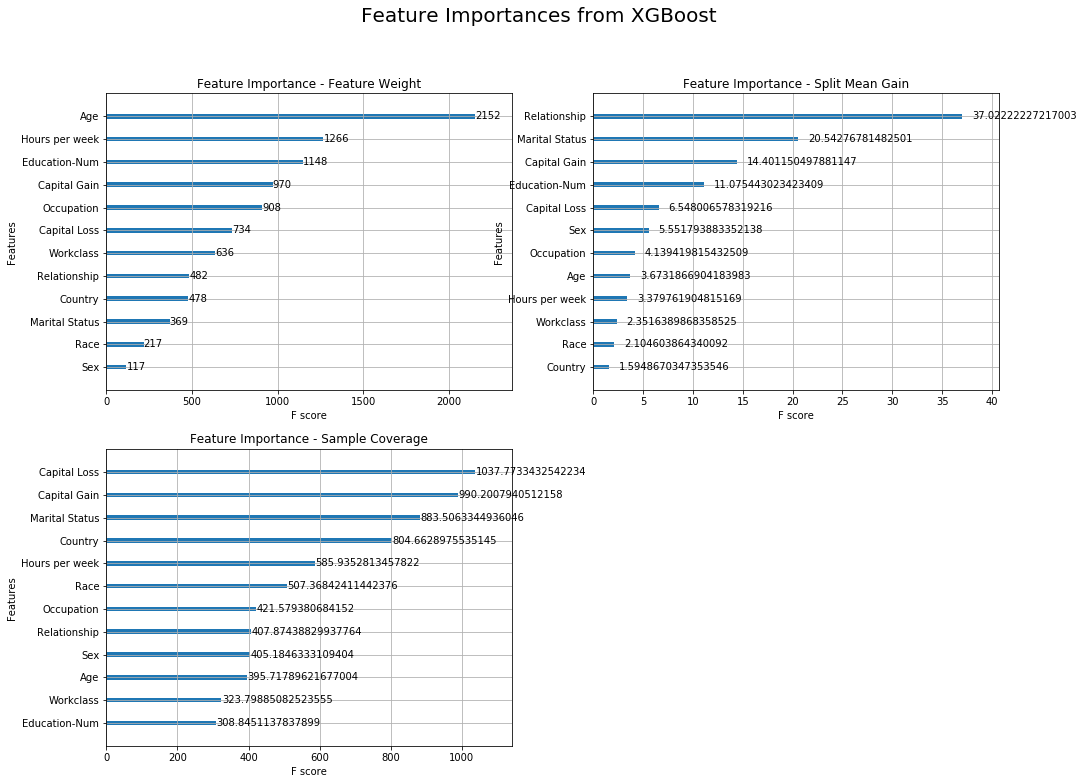

In [10]:
fig = plt.figure(figsize=(16, 12))
fig.suptitle("Feature Importances from XGBoost", fontsize=20)

ax1 = fig.add_subplot(2, 2, 1)
xgboost.plot_importance(xgbc, importance_type='weight', ax=ax1)
ax1.set_title('Feature Importance - Feature Weight')

ax2 = fig.add_subplot(2, 2, 2)
xgboost.plot_importance(xgbc, importance_type='gain', ax=ax2)
ax2.set_title('Feature Importance - Split Mean Gain')

ax3 = fig.add_subplot(2, 2, 3)
xgboost.plot_importance(xgbc, importance_type='cover', ax=ax3)
ax3.set_title('Feature Importance - Sample Coverage');

In [11]:
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti

In [12]:
rfc = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [13]:
y_Predicted = rfc.predict(X_test)

meu.display_model_performance_metrics(y_test, y_Predicted)

Model Performance metrics:
------------------------------
Accuracy: 0.8482
Precision: 0.8444
Recall: 0.8482
F1 Score: 0.8459

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.70      0.64      0.67      2314
           0       0.89      0.91      0.90      7455

   micro avg       0.85      0.85      0.85      9769
   macro avg       0.79      0.78      0.78      9769
weighted avg       0.84      0.85      0.85      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       1477   837
        0        646  6809


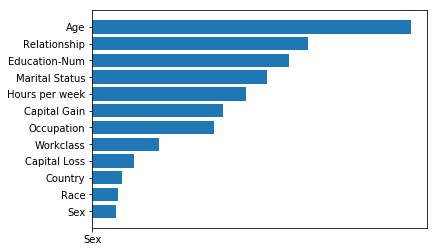

In [14]:
feats, importances = zip(*sorted(zip(X_test.columns, rfc.feature_importances_), key=lambda x: x[1]))
plt.xticks(range(len(feats)), feats)
plt.barh(feats, importances);

In [15]:
pred_10, bias, contribution = ti.predict(rfc, X_test[:10])

In [16]:
# Accuracy:
(pred_10.argmax(axis=1) == y_test[:10]).mean()

0.9

In [17]:
for i in range(3):
    p = pred_10[i].argmax()
    yi = y_test[i]
    print("ACTUAL/PREDICTED CLASS:", yi, '/', p)
    for c, f in sorted(zip(contribution[i], X_test.columns), reverse=True, key=lambda x: abs(x[0][0])):
        cc = c.argmax()
        print(f, "contributed", c.max().round(3),  "to class", cc, "- Correct class?", yi==cc)
    print()

ACTUAL/PREDICTED CLASS: 0 / 0
Relationship contributed 0.159 to class 0 - Correct class? True
Age contributed 0.13 to class 0 - Correct class? True
Hours per week contributed 0.06 to class 0 - Correct class? True
Education-Num contributed 0.047 to class 0 - Correct class? True
Sex contributed 0.035 to class 0 - Correct class? True
Capital Gain contributed 0.032 to class 0 - Correct class? True
Occupation contributed 0.023 to class 0 - Correct class? True
Marital Status contributed 0.007 to class 0 - Correct class? True
Capital Loss contributed 0.005 to class 0 - Correct class? True
Race contributed 0.001 to class 1 - Correct class? False
Workclass contributed 0.001 to class 0 - Correct class? True
Country contributed 0.001 to class 0 - Correct class? True

ACTUAL/PREDICTED CLASS: 0 / 1
Marital Status contributed 0.179 to class 1 - Correct class? False
Workclass contributed 0.153 to class 0 - Correct class? True
Education-Num contributed 0.115 to class 0 - Correct class? True
Relationsh

In [18]:
explainer = shap.TreeExplainer(xgbc)
shap_values = explainer.shap_values(X_test)

In [19]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_ORIG.iloc[0,:])

In [20]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test_ORIG.iloc[1,:])

In [21]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test_ORIG.iloc[2,:])

In [22]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test_ORIG.iloc[:1000,:])

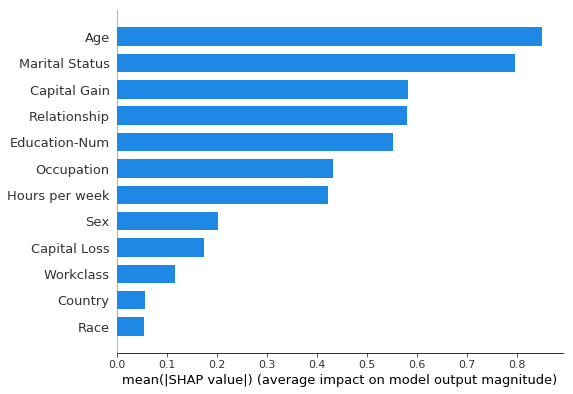

In [23]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

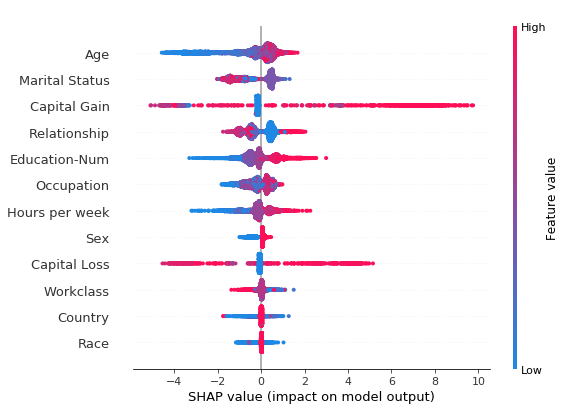

In [24]:
shap.summary_plot(shap_values, X_test)

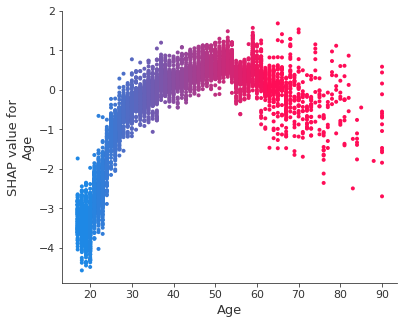

In [25]:
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_ORIG)

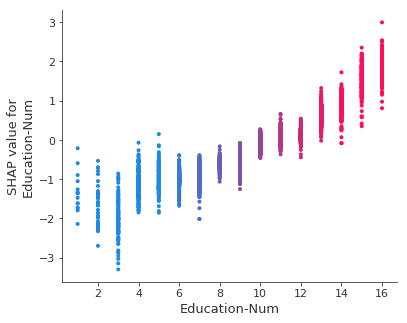

In [26]:
shap.dependence_plot(ind='Education-Num', interaction_index='Education-Num',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_ORIG)

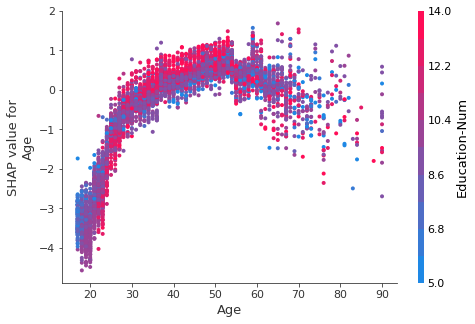

In [27]:
shap.dependence_plot(ind='Age', interaction_index='Education-Num', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_ORIG)

In [28]:
# https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook

import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
                "PIL": "Pillow",
                "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

xgboost==0.80
treeinterpreter==0.2.1
shap==0.26.0
scikit-learn==0.20.1
pandas==0.23.4
numpy==1.15.4
matplotlib==3.0.2
eli5==0.8.1
